In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
pd.set_option('display.max_colwidth', -1)

In [3]:
DATA_FOLDER = 'habits/'
answers_file = "questionnaire_answers.csv"
questions_file = 'questions_table.csv'
subquestionnaire_file ="questionnaire-subhabit_table.csv"
questionnaire_file = "questionnaire_table.csv"

# load the data
questionnaire_answers= pd.read_csv(DATA_FOLDER + answers_file, sep=',', error_bad_lines=False, encoding = "utf-8").dropna()
questionnaire_questions= pd.read_csv(DATA_FOLDER + questions_file, sep=',', error_bad_lines=False, encoding = "utf-8").dropna()
questionnaire = pd.read_csv(DATA_FOLDER + questionnaire_file, sep=',', skiprows = 1, error_bad_lines=False, encoding = "utf-8").dropna()
subquestionnaire= pd.read_csv(DATA_FOLDER + subquestionnaire_file, sep=',', error_bad_lines=False, encoding = "utf-8").dropna()

In [4]:
def get_corr(q_id, subquest, quest, answers, questions):
    is_sub = False
    nb_q_per_q = questionnaire_questions.groupby(['questionnaire identifier']).size().reset_index().rename(columns={0:'records'})
    # list of questionnaire that are composed of subquestionnaires
    is_split = list(subquest['reference habit identifier'])
    #list of subquestionnaires
    is_subq = list(subquest['subhabit identifier'])
    if (q_id in is_subq):
        is_sub = True
    list_q = []
    if (q_id in is_split):
        list_q = list(subquest.loc[subquest['reference habit identifier'] == q_id]['subhabit identifier'])
    else:
        list_q.append(q_id)
    nb_quest = 0
    frames = []
    for l in list_q:
        q_tmp = answers.loc[answers['questionnaire identifier'] == l]
        frames.append(q_tmp)
        nb_quest += int(nb_q_per_q.loc[nb_q_per_q['questionnaire identifier'] == l]['records'])
    
    # contains the answers for a given questionnaire
    q = pd.concat(frames)
    
    # get the list of ids of the users keeping only those that completed the entire questionnaire
    users = q.groupby(['user identifier']).size().reset_index().rename(columns={0:'records'})
    users = users.loc[users['records'] == nb_quest]
    
    frames = []
    i=0
    for u in users['user identifier']:
        u_tmp = q.loc[q['user identifier'] == u][['question identifier', 'score of the answer']].reset_index()[['score of the answer']].T
        frames.append(u_tmp)
        q_table = q.loc[q['user identifier'] == u][['question identifier']]

    # contains the answer for a given questionnaire sorted by user (1 line = 1 user; 1 row = 1 question)
    questions_table = pd.concat(frames)
    
    frames = []
    for r in q_table['question identifier']:
        r_tmp = questions.loc[questions['question identifier'] == r][['text', 'questionnaire identifier']]
        frames.append(r_tmp)
    questions_text = pd.concat(frames).reset_index()
    
    corr = questions_table.corr()
    title = ""
    if (is_sub):
        title = subquest.loc[subquest['subhabit identifier'] == q_id]['subhabit title'].iloc[0]    
    else:
        title = quest.loc[quest['questionnaire identifier'] == q_id]['questionnaire title'].iloc[0]
    sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),square=True).set_title(title)
    return questions_table, questions_text, users

Correlation between questions


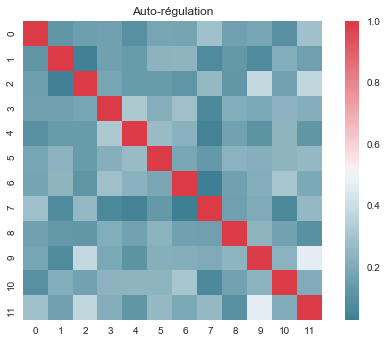

Number of users:  347 
No subquestionnaire


,text
0,"En classe, je manque souvent des points importants parce que je pense à autre chose."
1,"Lorsque je lis un document pour ce cours, je prépare des questions pour m’aider à cibler ma lecture."
2,"Lorsque je lis un document pour ce cours et que le contenu devient confus, je reviens en arrière et j’essaie de le comprendre."
3,"Si les documents du cours sont difficiles à comprendre, je change de technique de lecture."
4,"Avant d’étudier un nouveau document du cours en détails, je commence souvent par le parcourir rapidement pour voir comment il est organisé."
5,Je me pose des questions à moi-même pour être sûr que je comprends la matière que j’ai étudiée dans ce cours.
6,J’essaie de changer la façon dont j’étudie pour m’adapter aux spécificités du cours et à la façon dont l’enseignant·e enseigne.
7,"Je constate souvent que même si j’ai relu les documents du cours avant la classe, je ne sais plus ce dont il s’agissait."
8,"Lorsque j’étudie pour ce cours, j’essaie d’analyser les sujets et décider ce que je dois en retenir plutôt que de simplement relire les documents du cours attentivement."
9,"Lorsque j’étudie pour ce cours, j’essaie d’identifier les concepts que je n’ai pas bien compris."


,0,1,2,3,4,5,6,7,8,9,10,11
count,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000
mean,4.870317,2.602305,6.023055,3.942363,4.668588,4.377522,4.319885,4.899135,4.694524,5.599424,4.365994,5.190202
std,1.595844,1.561012,1.150290,1.697369,1.791831,1.680855,1.679090,1.649549,1.637370,1.206102,1.681692,1.449982
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4.000000,1.000000,6.000000,3.000000,3.000000,3.000000,3.000000,4.000000,3.000000,5.000000,3.000000,4.000000
50%,5.000000,2.000000,6.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000,5.000000,5.000000
75%,6.000000,3.000000,7.000000,5.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In [5]:
qt, qtt, u = get_corr(1, subquestionnaire, questionnaire, questionnaire_answers, questionnaire_questions)
print("Correlation between questions")
plt.show()
print("Number of users: ", u.shape[0], "\nNo subquestionnaire")
display(qtt[['text']])
display(qt.describe())


Correlation between questions


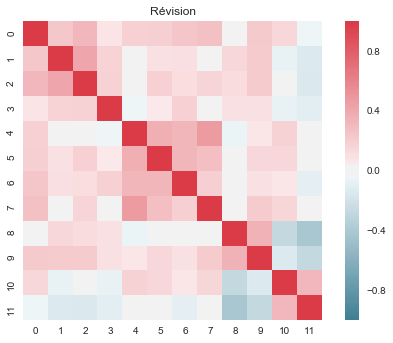

Number of users:  451 
Subquestionnaires: Faire des liens, Organiser les idées, Pratiquer le rappel


,text
0,"Lorsque j’étudie pour ce cours, je rassemble des informations provenant de différentes sources, comme mes notes de cours, les documents recommandés et les discussions."
1,"Lorsque je fais un exercice, j’essaie de voir en quoi il est relié aux concepts et idées du cours."
2,J’essaie de comprendre le contenu du cours en faisant des liens entre ce que j’ai lu et les concepts vus en classe.
3,J’essaie de voir comment les exercices sont reliés à des applications de la vie réelle.
4,"Lorsque j’étudie pour ce cours, je rédige de courts résumés des éléments essentiels."
5,"Lorsque j’étudie les documents pour ce cours, je fais un plan du contenu pour m’aider à organiser mes idées."
6,"Je fais des diagrammes, des schémas ou des tableaux pour m’aider à organiser le contenu du cours."
7,"Lorsque j’étudie pour ce cours, je passe en revue mes notes de cours et je fais une liste des concepts importants."
8,"Quand je travaille sur les exercices de ce cours, j’essaie en général de me souvenir au maximum du contenu du cours avant de regarder mes notes."
9,J’essaie de me tester pour voir si j’arrive à me rappeler des idées clés du cours.


,0,1,2,3,4,5,6,7,8,9,10,11
count,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.00000,451.000000,451.000000,451.000000
mean,5.159645,5.432373,5.407982,4.470067,3.975610,3.729490,4.363636,4.791574,5.04878,4.931264,4.421286,3.288248
std,1.441069,1.289864,1.303782,1.715515,2.029084,1.793196,1.785350,1.633271,1.61309,1.574004,1.880872,1.575174
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000
25%,4.000000,5.000000,5.000000,3.000000,2.000000,2.000000,3.000000,4.000000,4.00000,4.000000,3.000000,2.000000
50%,5.000000,6.000000,6.000000,4.000000,4.000000,4.000000,4.000000,5.000000,5.00000,5.000000,5.000000,3.000000
75%,6.000000,6.000000,6.000000,6.000000,6.000000,5.000000,6.000000,6.000000,6.00000,6.000000,6.000000,4.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.00000,7.000000,7.000000,7.000000


In [38]:
qt, qtt, u = get_corr(10, subquestionnaire, questionnaire, questionnaire_answers, questionnaire_questions)
print("Correlation between questions")
plt.show()
print("Number of users: ", u.shape[0], "\nSubquestionnaires: Faire des liens, Organiser les idées, Pratiquer le rappel")
display(qtt[['text']].style.apply(lambda x: ['background: lightgreen' if i < 4 else '' for i, _ in enumerate(x)])
.apply(lambda x : ['background: lightyellow' if i >= 4 and i < 8 else '' for i, _ in enumerate(x)])
.apply(lambda x : ['background: lightblue' if i >= 8 else '' for i, _ in enumerate(x)]))
display(qt.describe())

#MSLQ values / proportion of variance explained?
#8-9/10-11 : why
#4-7 : good
#all q vs 11 ? why
#0-2 ok + 3.
#8/4-7 no corr

Correlation between questions


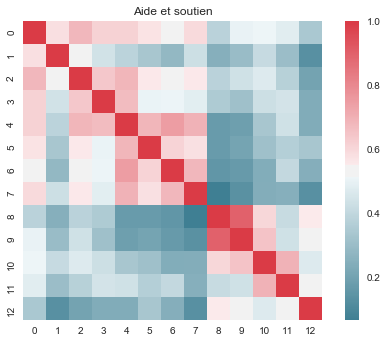

Number of users:  50 
Subquestionnaire: Soutien des camarades, Soutien des enseignant-e-s


,text
0,Je peux contacter d'autres étudiants de ma classe si j’ai des questions sur un travail à faire.
1,Les autres étudiants m’aident en me rappelant lorsque des travaux doivent être rendus ou quand un test approche.
2,"Si je manque un cours, je connais des étudiants qui pourraient me donner leurs notes."
3,Je retrouve des étudiants de ma classe en dehors des cours pour étudier.
4,Je discute avec les étudiants de ma classe d’événements qui se passent en dehors des cours.
5,"J’invite des étudiants de ma classe pour des activités, des loisirs ou des sorties en dehors des cours."
6,J’ai lié amitié avec d’autres étudiants de ma classe.
7,Il m’est arrivé de discuter de sujets personnels avec des étudiants de ma classe.
8,Je me sens à l’aise pour demander de l’aide à l’enseignant avant ou après le cours.
9,Je me sens à l’aise pour demander de l’aide à l’enseignant si je ne comprends pas quelque-chose en lien avec le cours.


,0,1,2,3,4,5,6,7,8,9,10,11,12
count,50.000000,50.00000,50.0000,50.000000,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,5.600000,4.76000,6.1600,4.760000,5.540000,4.720000,5.740000,5.38000,4.980000,5.220000,5.740000,4.720000,4.380000
std,1.807016,1.70904,1.0947,2.005706,1.704855,1.917056,1.411469,1.73664,1.609791,1.581655,1.536096,1.796141,1.904774
min,1.000000,1.00000,2.0000,1.000000,1.000000,1.000000,2.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,5.000000,4.00000,6.0000,3.250000,5.000000,3.000000,5.000000,5.00000,4.000000,4.000000,5.000000,4.000000,3.000000
50%,6.000000,5.00000,6.5000,5.000000,6.000000,5.000000,6.000000,6.00000,5.000000,6.000000,6.000000,5.000000,4.500000
75%,7.000000,6.00000,7.0000,6.000000,7.000000,6.000000,7.000000,7.00000,6.000000,6.000000,7.000000,6.000000,6.000000
max,7.000000,7.00000,7.0000,7.000000,7.000000,7.000000,7.000000,7.00000,7.000000,7.000000,7.000000,7.000000,7.000000


In [43]:
qt, qtt, u = get_corr(14, subquestionnaire, questionnaire, questionnaire_answers, questionnaire_questions)
print("Correlation between questions")
plt.show()
print("Number of users: ", u.shape[0], "\nSubquestionnaire: Soutien des camarades, Soutien des enseignant-e-s")
display(qtt[['text']].style.apply(lambda x: ['background: lightgreen' if i < 8 else 'background: lightyellow' for i, _ in enumerate(x)]))
display(qt.describe())